In [17]:
# !pip install -q bitsandbytes peft accelerate transformers datasets scipy matplotlib

In [1]:
import os
import bitsandbytes as bnb
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt
from datasets import load_dataset, concatenate_datasets
from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    DataCollatorForLanguageModeling,
    PreTrainedTokenizer,
)

In [2]:
model_id = "databricks/dolly-v2-3b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model =AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.model_max_length = 1024
max_length = 1024

In [3]:
model = prepare_model_for_kbit_training(model)

In [4]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

In [5]:
# To be added as special tokens
INSTRUCTION_KEY = "### Instruction:"
INPUT_KEY = "Input:"
RESPONSE_KEY = "### Response:"
END_KEY = "### End"
RESPONSE_KEY_NL = f"{RESPONSE_KEY}\n"

# training prompt that does not contain an input string.
INTRO_BLURB = (
    "Below is an instruction that describes a task. Write a response that appropriately completes the request."
)

In [6]:
PROMPT_NO_INPUT_FORMAT = """{intro}

{instruction_key}
{instruction}

{response_key}
{response}

{end_key}
""".format(
    intro=INTRO_BLURB,
    instruction_key=INSTRUCTION_KEY,
    instruction="{instruction}",
    response_key=RESPONSE_KEY,
    response="{response}",
    end_key=END_KEY,
)


# This is the prompt that is used for generating responses using an already trained model.  It ends with the response
# key, where the job of the model is to provide the completion that follows it (i.e. the response itself).
PROMPT_WITH_INPUT_FORMAT = """{intro}

{instruction_key}
{instruction}

{input_key}
{context}

{response_key}
{response}

{end_key}
""".format(
    intro=INTRO_BLURB,
    instruction_key=INSTRUCTION_KEY,
    instruction="{instruction}",
    input_key=INPUT_KEY,
    context="{context}",
    response_key=RESPONSE_KEY,
    response="{response}",
    end_key=END_KEY
)

In [7]:
dataset = load_dataset("squad_v2")
dataset = dataset.map(
    lambda x: {
        "response": x["answers"]["text"][0] if len(x["answers"]["text"]) > 0 else "I cannot answer based on my knowledge.",
    },
)
dataset_train = dataset["train"].shuffle().select(range(30000))
dataset_test = dataset["validation"].shuffle().select(range(1000))

# load dataset from csv file
dataset2 = load_dataset("csv", data_files="LLM dataset train clean.csv")["train"]
dataset2 = dataset2.rename_column("instruction", "question")

In [8]:
dataset_train = concatenate_datasets([dataset_train, dataset2])

In [9]:
def format_for_LLM(rec):
    instruction = rec["question"]
    instruction = "Answer the following question only with the provided input. If no answer is found tell that you cannot answer based on this context. " + instruction
    response = rec["response"]
    context = rec.get("context")
    if context:
        rec["text"] = PROMPT_WITH_INPUT_FORMAT.format(
            instruction=instruction, 
            response=response, 
            context=context
        )
    else:
        rec["text"] = PROMPT_NO_INPUT_FORMAT.format(
            instruction=instruction, 
            response=response
        )
    return rec

In [10]:
dataset_train = dataset_train.map(format_for_LLM)
dataset_test = dataset_test.map(format_for_LLM)

Map:   0%|          | 0/30141 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [11]:
def generate_and_tokenize_text(rec):
  tokenized_full_prompt = tokenizer(rec['text'], padding=True, truncation=True)
  return tokenized_full_prompt

In [12]:
dataset_train = dataset_train.map(generate_and_tokenize_text)
dataset_test = dataset_test.map(generate_and_tokenize_text)

Map:   0%|          | 0/30141 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
# Make sure we don't have any truncated records, as this would mean the end keyword is missing.
dataset_train = dataset_train.filter(lambda rec: len(rec["input_ids"]) < max_length)
dataset_test = dataset_test.filter(lambda rec: len(rec["input_ids"]) < max_length)

Filter:   0%|          | 0/30141 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [14]:
dataset_train

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'response', 'text', 'input_ids', 'attention_mask'],
    num_rows: 30140
})

In [15]:
dataset_test

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'response', 'text', 'input_ids', 'attention_mask'],
    num_rows: 1000
})

In [16]:
class DataCollatorForCompletionOnlyLM(DataCollatorForLanguageModeling):
    def torch_call(self, examples):
        batch = super().torch_call(examples)

        # The prompt ends with the response key plus a newline
        response_token_ids = self.tokenizer.encode(RESPONSE_KEY_NL)
        labels = batch["labels"].clone()

        for i in range(len(examples)):
            response_token_ids_start_idx = None
            for idx in np.where(batch["labels"][i] == response_token_ids[0])[0]:
                response_token_ids_start_idx = idx
                break

            if response_token_ids_start_idx is None:
                raise RuntimeError(
                    f'Could not find response key {response_token_ids} in token IDs {batch["labels"][i]}'
                )

            response_token_ids_end_idx = response_token_ids_start_idx + 1

            # loss function ignore all tokens up through the end of the response key
            labels[i, :response_token_ids_end_idx] = -100

        batch["labels"] = labels

        return batch

In [17]:
data_collator = DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, mlm=False, return_tensors="pt")

In [18]:
training_args = transformers.TrainingArguments(
    auto_find_batch_size=True,
    num_train_epochs=4,
    learning_rate=1e-5,
    bf16=True,
    logging_steps=50,
    logging_strategy="steps",
    do_eval=True,
    evaluation_strategy='steps',
    save_strategy='steps',
    save_steps=200,
    output_dir='./FineTunedDolly2Squadv2',
)

In [19]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    args=training_args,
    data_collator=data_collator,
)
model.config.use_cache = False
trainer.train()

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
50,1.288000,0.828185
100,0.554500,0.386818
150,0.403100,0.329670
200,0.398200,0.311820
250,0.380200,0.289691
300,0.390500,0.290060
350,0.347100,0.274892
400,0.339200,0.265277
450,0.316200,0.266414
500,0.288600,0.248203


TrainOutput(global_step=15072, training_loss=0.2007426868040597, metrics={'train_runtime': 22959.4381, 'train_samples_per_second': 5.251, 'train_steps_per_second': 0.656, 'total_flos': 3.449354524939469e+17, 'train_loss': 0.2007426868040597, 'epoch': 4.0})

In [20]:
losses = []
eval_losses = []

for row in trainer.state.log_history:
    if 'loss' in row:
        losses.append(row['loss'])
    if 'eval_loss' in row:
        eval_losses.append(row['eval_loss'])

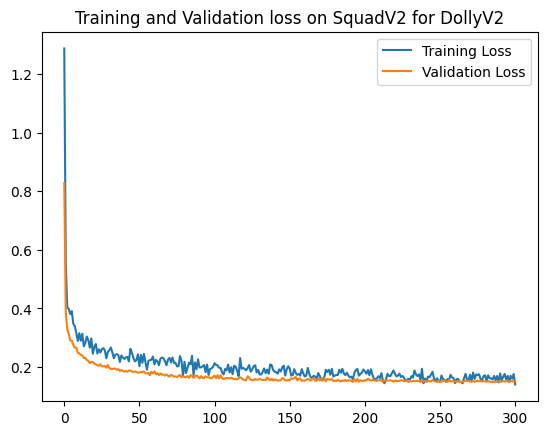

In [21]:
plt.plot(losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.title('Training and Validation loss on SquadV2 for DollyV2')
plt.legend()
plt.show()

In [ ]:
# Generation Sector

In [ ]:
PROMPT_FOR_GENERATION_FORMAT = """{intro}

{instruction_key}
{instruction}

{response_key}
""".format(
    intro=INTRO_BLURB,
    instruction_key=INSTRUCTION_KEY,
    instruction="{instruction}",
    response_key=RESPONSE_KEY,
)


# This is the prompt that is used for generating responses using an already trained model.  It ends with the response
# key, where the job of the model is to provide the completion that follows it (i.e. the response itself).
PROMPT_FOR_GENERATION_FORMAT_WITH_INPUT = """{intro}

{instruction_key}
{instruction}

{input_key}
{context}

{response_key}
""".format(
    intro=INTRO_BLURB,
    instruction_key=INSTRUCTION_KEY,
    instruction="{instruction}",
    input_key=INPUT_KEY,
    context="{context}",
    response_key=RESPONSE_KEY,
)

In [ ]:
def get_special_token_id(tokenizer: PreTrainedTokenizer, key: str) -> int:
    """Gets the token ID for a given string that has been added to the tokenizer as a special token.
    When training, we configure the tokenizer so that the sequences like "### Instruction:" and "### End" are
    treated specially and converted to a single, new token.  This retrieves the token ID each of these keys map to.
    Args:
        tokenizer (PreTrainedTokenizer): the tokenizer
        key (str): the key to convert to a single token
    Raises:
        RuntimeError: if more than one ID was generated
    Returns:
        int: the token ID for the given key
    """
    token_ids = tokenizer.encode(key)
    # if len(token_ids) > 1:
    #     raise ValueError(f"Expected only a single token for '{key}' but found {token_ids}")
    return token_ids[0]

def preprocess(tokenizer, instruction_text, context_text=None):
    instruction = "Answer the following question only with the provided input. If no answer is found tell that you cannot answer based on this context. " + instruction_text
    if context_text:
        prompt_text = PROMPT_FOR_GENERATION_FORMAT_WITH_INPUT.format(instruction=instruction, context=context_text)
    else:
        prompt_text = PROMPT_FOR_GENERATION_FORMAT.format(instruction=instruction)
    print(prompt_text)
    inputs = tokenizer(prompt_text, return_tensors="pt",)
    inputs["prompt_text"] = prompt_text
    inputs["instruction_text"] = instruction_text
    inputs["context_text"] = context_text
    return inputs

def forward(model, tokenizer, model_inputs, max_length=256):
    input_ids = model_inputs["input_ids"]
    attention_mask = model_inputs.get("attention_mask", None)

    if input_ids.shape[1] == 0:
        input_ids = None
        attention_mask = None
        in_b = 1
    else:
        in_b = input_ids.shape[0]

    generated_sequence = model.generate(
        input_ids=input_ids.to(model.device),
        attention_mask=attention_mask.to(model.device),
        pad_token_id=tokenizer.pad_token_id,
        max_length=max_length
    )

    out_b = generated_sequence.shape[0]
    generated_sequence = generated_sequence.reshape(in_b, out_b // in_b, *generated_sequence.shape[1:])
    instruction_text = model_inputs.pop("instruction_text", None)

    return {
        "generated_sequence": generated_sequence, 
        "input_ids": input_ids,
    }


def postprocess(tokenizer, model_outputs):
    response_key_token_id = get_special_token_id(tokenizer, RESPONSE_KEY_NL)
    end_key_token_id = get_special_token_id(tokenizer, END_KEY)
    generated_sequence = model_outputs["generated_sequence"][0]
    
    # send it to cpu
    generated_sequence = generated_sequence.cpu()
    generated_sequence = generated_sequence.numpy().tolist()
    records = []

    for sequence in generated_sequence:
        decoded = None

        try:
            response_pos = sequence.index(response_key_token_id)
        except ValueError:
            print(f"Could not find response key {response_key_token_id} in: {sequence}")
            response_pos = None

        if response_pos:
            try:
                end_pos = sequence.index(end_key_token_id)
            except ValueError:
                print("Could not find end key, the output is truncated!")
                end_pos = None
            decoded = tokenizer.decode(sequence[response_pos + 1 : end_pos], skip_special_tokens=True).strip()
            
        if not decoded:
            # Otherwise we'll decode everything and use a regex to find the response and end.

            fully_decoded = tokenizer.decode(sequence)
            # The response appears after "### Response:".  The model has been trained to append "### End" at the
            # end.
            m = re.search(r"#+\s*Response:\s*(.+?)#+\s*End", fully_decoded, flags=re.DOTALL)
            if m:
                decoded = m.group(1).strip()
            else:
                # The model might not generate the "### End" sequence before reaching the max tokens.  In this case,
                # return everything after "### Response:".
                m = re.search(r"#+\s*Response:\s*(.+)", fully_decoded, flags=re.DOTALL)
                if m:
                    decoded = m.group(1).strip()
                else:
                    print(f"Failed to find response in:\n{fully_decoded}")
            
            
        rec = {"generated_text": decoded}
        records.append(rec)
    return records

In [ ]:

text = 'Does marble can handle high nature forces?'
context = 'Marble is a very strong material, although being capable of withstanding high forces from nature the marble can have cracks. These can be addressed by filling them with grout a special composition of dust and cement with high dumping solutions.'
pre_process_result = preprocess(tokenizer, text, context)
model_result = forward(model, tokenizer, pre_process_result)
final_output = postprocess(tokenizer, model_result);
print('LLM response: ', final_output[0]['generated_text'])

In [ ]:
trainer.save_model(output_dir=local_output_dir);
tokenizer.save_pretrained(local_output_dir);